<a href="https://colab.research.google.com/github/fatimasr68/DNN/blob/master/LSTM_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Imports**

In [1]:
import keras
import keras.backend as K
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, LeakyReLU, Dropout
from keras import layers
from keras import optimizers, activations, regularizers, initializers
from keras.regularizers import L1L2
from keras.models import Model, Sequential
from keras.layers.recurrent import LSTM, GRU

from sklearn import metrics
from scipy import stats
import tensorflow as tf
import tensorflow.keras

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping

import os


Using TensorFlow backend.


## **Setup seed**

In [2]:
seed = 8000

np.random.seed(seed)
np.random.RandomState(seed)
tf.random.set_seed(seed)

# **Data**

## **Load Data**

In [3]:
data = sio.loadmat('/content/drive/My Drive/Colab Notebooks/emt_valence_sample.mat')


train_x_ =  data["train_x"]
train_y_ = data["train_y"]
test_x_  = data["test_x"]
test_y_  = data["test_y"]

In [4]:
X = np.vstack([train_x_, test_x_])     #total_x
Y = np.hstack([train_y_, test_y_]).T   #total_y


X = pd.DataFrame(X)

## **Feature Selection**

In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler


X_norm = MinMaxScaler().fit_transform(X)

chi_selector = SelectKBest(chi2, k = 2500)
chi_selector.fit(X_norm, Y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:, chi_support]

X = chi_feature.to_numpy()


Y = Y / 10.0


## **Split into training and test set**

In [6]:
np.random.RandomState(seed)

# select 64 shuffle indexes
ind_train = np.random.permutation(64)  
ind_test  = np.random.permutation(16)

x_train = train_x_[ind_train]
y_train = train_y_.astype('float32') # / 10

x_test = test_x_[ind_test]
y_test = test_y_.astype('float32') # / 10

y_train = y_train.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)


x_train = pd.DataFrame(x_train)
x_test  = pd.DataFrame(x_test)

In [7]:
# Feature Selection
X_tr_norm = MinMaxScaler().fit_transform(x_train)
X_ts_norm = MinMaxScaler().fit_transform(x_test)

chi_selector = SelectKBest(chi2, k = 2500)

chi_selector.fit(X_tr_norm, y_train)
chi_selector.fit(X_ts_norm, y_test)

chi_support = chi_selector.get_support()
chi_feature = x_train.loc[:, chi_support]
chi_feature = x_test.loc[:, chi_support]

x_train = chi_feature.to_numpy()
x_test = chi_feature.to_numpy()


y_train = y_train / 10.0
y_test = y_test / 10.0

# **Parameters of DNN**

In [8]:
[n_in, n_hidden1, n_hidden2, n_hidden3, n_output] = [2500, 150, 50, 0, 1] #150, 50

n_epochs = 600
batch_size = 32
k_folds = 5

timesteps = 1

#Regularizer Parameters
l1 = 0    # 1e-5 :0.66 
l2 = 0    #1e-7:0.61

# **Custom Metrics**

In [9]:
import keras.backend as K

def mean_pred(y_true, y_pred):
  return K.mean(y_pred)


def STD_pred(y_true, y_pred):
  return K.std(y_pred)

def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis= -1))
 

def CC(y_true, y_pred):
  fsp = y_pred - K.mean(y_pred) 
  fst = y_true - K.mean(y_true)

  devP = K.std(y_pred)
  devT = K.std(y_true)

  return K.mean(fsp * fst) / (devP * devT)


# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))


# **Callbacks**

In [10]:
class prediction_history(keras.callbacks.Callback):
    def __init__(self):
        self.pred_train = []
        self.pred_test  = []
        self.epochs_ = 0
        self.CC_thresh = 1
        self.CC_test_mean = []

    def rmse(self, y_test, y_pred):
      return np.sqrt(np.mean(np.square(y_pred - y_test), axis= -1))

    def CC(self, y_test, y_pred):
        fsp = y_pred - np.mean(y_pred) 
        fst = y_test - np.mean(y_test)
        devP = np.std(y_pred)
        devT = np.std(y_test)
        return np.mean(fsp * fst) / (devP * devT)

    def on_epoch_end(self, epoch, logs={}):
        self.epochs_ = self.epochs_ + 1
        prediction_train = model.predict(x_tr)
        prediction_test = model.predict(x_val)
        self.pred_train.append(prediction_train)
        self.pred_test.append(prediction_test)
        
        CC_train = self.CC(y_tr, prediction_train)
        CC_test  = self.CC(y_val, prediction_test)
        rmse_test = np.sqrt(metrics.mean_squared_error(y_val, prediction_test))

        self.CC_test_mean.append(CC_test)

        print(self.epochs_ , CC_train, CC_test, rmse_test)

  
        if (self.epochs_ > 200 and CC_train > 0.95 and CC_test > 0.68 and rmse_test < 0.11):
          #self.model.stop_training = True
          print("STOP!")

# **DNN**

## **Create & Compile Model**

In [11]:
def create_model():

  model = Sequential()

  model.add(LSTM(units= n_hidden1,  
                dropout= 0.2, #0.2
                recurrent_dropout= 0.5,
                activation = 'relu',
                inner_activation = 'sigmoid',

                bias_regularizer = L1L2(l1= l1, l2= l2),
                kernel_regularizer = L1L2(l1= l1, l2= l2),
                activity_regularizer = L1L2(l1= l1, l2= l2),

                kernel_initializer = initializers.he_normal(),
                return_sequences= True,
                input_shape=(timesteps, n_in)))  


  #model.add(Dropout(0.2))

  model.add(LSTM(units= n_hidden2,  
                dropout= 0.5, 
                recurrent_dropout= 0.5,
                activation = 'sigmoid',
                inner_activation = 'sigmoid',

                bias_regularizer = L1L2(l1= l1, l2= l2),
                kernel_regularizer = L1L2(l1= l1, l2= l2),
                activity_regularizer = L1L2(l1= l1, l2= l2),
                 
                #kernel_initializer = initializers.he_uniform(),
                kernel_initializer = initializers.orthogonal(),
                return_sequences= False))

  model.add(Dense(units= n_output, 
                  activation= 'linear'))




  # rmsprop(learning_rate= 0.001, rho = 0.9)  0.61
  # adam(learning_rate= 0.001)  0.60
  # adamax(learning_rate= 0.001)  0.60
  # SGD(learning_rate= 0.1, decay= 0.0001, momentum= 0.9) 0.60
  # adagrad(learning_rate= 0.01)  0.58

  model.compile(optimizer= optimizers.rmsprop(learning_rate= 0.0001, rho = 0.9), 
                loss= keras.losses.mean_squared_error,
                metrics= ['mse', 'mae', 'mape', rmse, CC, mean_pred, STD_pred])
  


  return model


model = create_model()
model.summary()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, dropout=0.2, recurrent_dropout=0.5, activation="relu", bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg..., activity_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., return_sequences=True, input_shape=(1, 2500), recurrent_activation="sigmoid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, dropout=0.5, recurrent_dropout=0.5, activation="sigmoid", bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg..., activity_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., return_sequences=False, recurrent_activation="sigmoid")`


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 150)            1590600   
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                40200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 1,630,851
Trainable params: 1,630,851
Non-trainable params: 0
_________________________________________________________________


## **Train model with K-fold CV**

In [12]:
CV_history = [] 

val_data_x = []
val_data_y = []

train_data_x = []
train_data_y = []

pred_val_tr = []
pred_val_ts = []


MSEs  = []
MAEs  = []
MAPEs = []
RMSEs = []
CCs   = []

fold_no = 0 

for train_index, val_index in KFold(n_splits= k_folds, shuffle= True, random_state= seed).split(X, Y):

  x_tr, x_val = X[train_index], X[val_index]
  y_tr, y_val = Y[train_index], Y[val_index]

  fold_no += 1

  print('-------------------------------------------------------------------------------')
  print('Training for fold ', fold_no)
  print('-------------------------------------------------------------------------------')


  train_data_x.append(X[train_index])
  train_data_y.append(Y[train_index])
  val_data_x.append(X[val_index])
  val_data_y.append(Y[val_index])

  x_tr  = np.reshape(x_tr , (x_tr.shape[0] , 1, x_tr.shape[1] ))
  x_val = np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1])) 

  model = None
  model = create_model()


  cbk = prediction_history()


  results = model.fit(x_tr, y_tr, epochs= n_epochs,
                          batch_size= batch_size,
                          callbacks = [cbk],
                          verbose = False,
                          validation_data = [x_val, y_val]
                        )


  pred_val_tr.append(model.predict(x_tr))
  pred_val_ts.append(model.predict(x_val))


  scores = model.evaluate(x_val, y_val)
  print("%s: %.2f" % (model.metrics_names[1], scores[1] ))   #MSE
  MSEs.append(scores[1])
  print("%s: %.2f" % (model.metrics_names[2], scores[2] ))   #MAE
  MAEs.append(scores[2])
  print("%s: %.2f" % (model.metrics_names[3], scores[3] ))   #MAPE
  MAPEs.append(scores[3])
  print("%s: %.2f" % (model.metrics_names[4], scores[4] ))   #RMSE
  RMSEs.append(scores[4])
  print("%s: %.2f" % (model.metrics_names[5], scores[5] ))   #CC
  CCs.append(scores[5])


  CV_history.append(results)
  print("======="*12, end="\n\n\n")



-------------------------------------------------------------------------------
Training for fold  1
-------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, dropout=0.2, recurrent_dropout=0.5, activation="relu", bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg..., activity_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., return_sequences=True, input_shape=(1, 2500), recurrent_activation="sigmoid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, dropout=0.5, recurrent_dropout=0.5, activation="sigmoid", bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg..., activity_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., return_sequences=False, recurrent_activation="sigmoid")`


1 0.56015855 0.44368476 0.18098576
2 0.52674884 0.45089078 0.17551054
3 0.74365807 0.7294078 0.16391322
4 0.76052 0.74666446 0.15709646
5 0.76892835 0.7489759 0.15248261
6 0.761687 0.7662244 0.15167296
7 0.79441833 0.7544904 0.14772226
8 0.79516256 0.76181597 0.14690375
9 0.81935793 0.75681216 0.14278595
10 0.80045766 0.7740537 0.14548184
11 0.81197524 0.7752584 0.14278804
12 0.8211451 0.77352494 0.14158146
13 0.84455186 0.76803845 0.13706926
14 0.82080734 0.7745593 0.14391267
15 0.83713305 0.7677766 0.1428513
16 0.8584722 0.76922315 0.13579635
17 0.84327084 0.7775889 0.1412114
18 0.86730653 0.7874482 0.13218883
19 0.8721384 0.7891113 0.13170414
20 0.8586878 0.7902258 0.14131674
21 0.8818719 0.7914137 0.13235897
22 0.8829763 0.79620725 0.13118654
23 0.8668418 0.7956885 0.14281468
24 0.89185566 0.7981411 0.13064195
25 0.8851639 0.79627645 0.14112039
26 0.9086033 0.8030748 0.1296412
27 0.88426185 0.7936975 0.14359649
28 0.901816 0.79273635 0.13762327
29 0.9162666 0.797614 0.13102163
30 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, dropout=0.2, recurrent_dropout=0.5, activation="relu", bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg..., activity_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., return_sequences=True, input_shape=(1, 2500), recurrent_activation="sigmoid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, dropout=0.5, recurrent_dropout=0.5, activation="sigmoid", bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg..., activity_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., return_sequences=False, recurrent_activation="sigmoid")`


1 0.40557325 0.768354 0.16856353
2 0.42613572 0.7751076 0.14861028
3 0.4421723 0.7806816 0.14795135
4 0.45874435 0.78409594 0.1373451
5 0.47298777 0.78718305 0.13068752
6 0.48964196 0.79275626 0.12564586
7 0.49581733 0.79051197 0.121312045
8 0.5153368 0.7935339 0.11827379
9 0.5382139 0.7971338 0.11665217
10 0.5545597 0.80143994 0.11421689
11 0.5617829 0.80093014 0.10623587
12 0.6003955 0.8027308 0.11561462
13 0.6020037 0.80418277 0.10275873
14 0.60889745 0.80469364 0.09844737
15 0.63333726 0.8021029 0.09785952
16 0.66741306 0.7990652 0.10158865
17 0.69039565 0.79549384 0.10215911
18 0.68136054 0.8005048 0.09388643
19 0.7190809 0.789991 0.10043598
20 0.7291794 0.7907086 0.09931092
21 0.7445155 0.7856671 0.09788119
22 0.7530236 0.78765315 0.094309464
23 0.760127 0.78500944 0.09370992
24 0.7755494 0.7791729 0.094570525
25 0.81121385 0.7504737 0.10539815
26 0.8181391 0.75308496 0.10180311
27 0.8132433 0.7618099 0.09725493
28 0.84849554 0.7230041 0.11040032
29 0.8433316 0.74770886 0.1017535

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, dropout=0.2, recurrent_dropout=0.5, activation="relu", bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg..., activity_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., return_sequences=True, input_shape=(1, 2500), recurrent_activation="sigmoid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, dropout=0.5, recurrent_dropout=0.5, activation="sigmoid", bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg..., activity_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., return_sequences=False, recurrent_activation="sigmoid")`


1 -0.51199806 -0.27876306 0.4236374
2 -0.48779994 -0.25688586 0.3870791
3 -0.4647273 -0.24001959 0.36952165
4 -0.43609953 -0.22906448 0.36108044
5 -0.40301105 -0.2141871 0.3508265
6 -0.3578173 -0.19927658 0.33863768
7 -0.32917228 -0.18521295 0.33153147
8 -0.2918749 -0.17088062 0.3231716
9 -0.2404287 -0.14780027 0.31058955
10 -0.20683925 -0.13054529 0.30529147
11 -0.1710026 -0.11626147 0.300206
12 -0.12199621 -0.10274678 0.2923409
13 -0.071844265 -0.085940756 0.28417
14 -0.027024467 -0.075995855 0.27864474
15 0.037333813 -0.06012004 0.27086958
16 0.103884995 -0.035386242 0.26320326
17 0.14358108 -0.021789763 0.259573
18 0.2245906 0.0043669855 0.25057513
19 0.27437416 0.014429173 0.2451877
20 0.2730902 0.014710876 0.24760635
21 0.38106123 0.047847226 0.2325338
22 0.38078028 0.044182427 0.23631752
23 0.44258094 0.064052016 0.22947979
24 0.4674984 0.0704589 0.22838326
25 0.4642008 0.065567344 0.23200837
26 0.5032472 0.07790749 0.22686417
27 0.5762838 0.11370929 0.2133272
28 0.5773022 0.107

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, dropout=0.2, recurrent_dropout=0.5, activation="relu", bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg..., activity_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., return_sequences=True, input_shape=(1, 2500), recurrent_activation="sigmoid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, dropout=0.5, recurrent_dropout=0.5, activation="sigmoid", bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg..., activity_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., return_sequences=False, recurrent_activation="sigmoid")`


1 0.5833569 0.7118273 0.16738053
2 0.6351132 0.759807 0.15687436
3 0.67199737 0.79605323 0.14681621
4 0.68198454 0.80487525 0.142241
5 0.7106822 0.8086926 0.13624635
6 0.7317739 0.81587183 0.1317234
7 0.72293067 0.8201319 0.13684843
8 0.72343934 0.8226684 0.14224748
9 0.75569266 0.82616085 0.13107213
10 0.78162223 0.82249874 0.12591055
11 0.79544574 0.8197855 0.12205693
12 0.77248174 0.83026075 0.13479558
13 0.8022519 0.8260152 0.12333046
14 0.8143936 0.8291522 0.12439946
15 0.83461994 0.82413363 0.120127074
16 0.82798123 0.8344555 0.1225751
17 0.829857 0.8425279 0.12508939
18 0.8511398 0.8417006 0.11980023
19 0.84831667 0.8457704 0.12443718
20 0.86969084 0.84196854 0.11225415
21 0.86627305 0.84955716 0.11800854
22 0.8772053 0.84662384 0.1105566
23 0.8865527 0.84125286 0.109685265
24 0.8873305 0.84822017 0.11317583
25 0.88696957 0.85714084 0.11783557
26 0.86608887 0.86044484 0.13947104
27 0.9103877 0.8521093 0.10708642
28 0.8961168 0.8665593 0.12171321
29 0.8894315 0.8682279 0.1294776


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, dropout=0.2, recurrent_dropout=0.5, activation="relu", bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg..., activity_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., return_sequences=True, input_shape=(1, 2500), recurrent_activation="sigmoid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, dropout=0.5, recurrent_dropout=0.5, activation="sigmoid", bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg..., activity_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., return_sequences=False, recurrent_activation="sigmoid")`


1 -0.08866874 0.17650552 0.18793602
2 0.01641251 0.23783752 0.17222482
3 0.114891365 0.27281383 0.16061921
4 0.18074822 0.30317113 0.1517548
5 0.48018876 0.3280762 0.15256363
6 0.5489625 0.33708328 0.14809896
7 0.6432165 0.33555886 0.14840281
8 0.6124445 0.35021168 0.13961557
9 0.6083512 0.35806042 0.1347045
10 0.6850606 0.35867715 0.13625367
11 0.6528357 0.37101254 0.12880695
12 0.67078966 0.378369 0.12659425
13 0.69639844 0.39117974 0.12442223
14 0.6986122 0.3979497 0.12161497
15 0.7046544 0.40816146 0.11984635
16 0.7245703 0.4139868 0.119023114
17 0.7610176 0.41081393 0.120290235
18 0.7746339 0.4127139 0.1188786
19 0.7822257 0.4199884 0.116555475
20 0.79792136 0.42673472 0.11600781
21 0.8061005 0.44236857 0.11364456
22 0.818712 0.43231362 0.115350716
23 0.8224312 0.4483605 0.111772686
24 0.8314912 0.44021103 0.11336966
25 0.8354014 0.4586221 0.10998761
26 0.8411541 0.47636417 0.107263975
27 0.8533946 0.46145362 0.10876783
28 0.86362886 0.44014904 0.111352734
29 0.86820436 0.42727908

# **Evaluate**

## **Evaluate Model**

In [13]:
# == Provide average scores ==
print('-----------------------------' * 4)
print('Results per fold: ')
for i in range(0, len(CCs)):
  print('-----------------------------' * 4)
  print(f'Fold {i+1} - MSE: {MSEs[i]} - MAE: {MAEs[i]} - MAPE: {MAPEs[i]} - CC: {CCs[i]}')
print('-----------------------------' * 4)
print('Average scores for all folds:')

print("\nMSE:  %.2f (+/-) %.2f" % (np.mean(MSEs) , np.std(MSEs) ))
print("\nMAE:  %.2f (+/-) %.2f" % (np.mean(MAEs) , np.std(MAEs) ))
print("\nRMSE: %.2f (+/-) %.2f" % (np.mean(RMSEs), np.std(RMSEs)))
print("\nMAPE: %.2f (+/-) %.2f" % (np.mean(MAPEs), np.std(MAPEs)))
print("\nCC:   %.2f (+/-) %.2f" % (np.mean(CCs)  , np.std(CCs)  ))
print('----------------------------' * 4)

--------------------------------------------------------------------------------------------------------------------
Results per fold: 
--------------------------------------------------------------------------------------------------------------------
Fold 1 - MSE: 0.015194769017398357 - MAE: 0.09460285305976868 - MAPE: 19.239604949951172 - CC: 0.8383112549781799
--------------------------------------------------------------------------------------------------------------------
Fold 2 - MSE: 0.014592268504202366 - MAE: 0.08886383473873138 - MAPE: 27.63819694519043 - CC: 0.5818876028060913
--------------------------------------------------------------------------------------------------------------------
Fold 3 - MSE: 0.021728411316871643 - MAE: 0.10876503586769104 - MAPE: 36.873748779296875 - CC: 0.5331031680107117
--------------------------------------------------------------------------------------------------------------------
Fold 4 - MSE: 0.00942009873688221 - MAE: 0.068556882441

## **Box Plot**

notch=None, sym=None, vert=None, whis=None, positions=None, widths=None, patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, meanline=None, showmeans=None, showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None, meanprops=None, capprops=None, whiskerprops=None, manage_ticks=True, autorange=False, zorder=None, *, data=None

In [14]:
labels = ['LSTM 1']
boxprops = dict(linestyle='-', linewidth=3, color='#00BFFF')
flierprops = dict(marker='o', markerfacecolor='green', markersize=12, linestyle='none')
medianprops = dict(linestyle='-.', linewidth=2.5, color='#00BFFF')
meanpointprops = dict(marker='D', markeredgecolor='red', markerfacecolor='yellow', markersize=7)
meanlineprops = dict(linestyle='-', linewidth=2, color='orange')

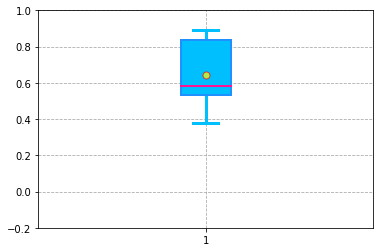

In [15]:
## to get fill color
bp = plt.boxplot(CCs, 
                 patch_artist = True,
                 showmeans = True,
                 meanprops = meanpointprops,
                 )

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#1E90FF', linewidth=2)
    # change fill color
    box.set( facecolor = '#00BFFF' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#00BFFF', linewidth=3)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#00BFFF', linewidth=3)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#FF1493', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#9c0', alpha=0.5)

for mean in bp['means']:
    mean.set(marker='o', color='#000', alpha=0.7)

plt.ylim(-0.2, 1)
plt.grid(color='#aaa', ls = '--')
plt.show()    

# **Plots**

## **MSE of Folds**

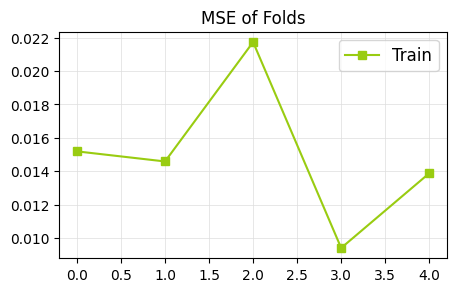

In [16]:
plt.figure(figsize=(5, 3), dpi=100)
ax = plt.plot(MSEs, label='Train', marker='s', color='#99cc11')


plt.title('MSE of Folds')
xtickslocs = np.arange(1, 5, step=1)
plt.legend(loc='best', fontsize='large')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

## **MAE of Folds**

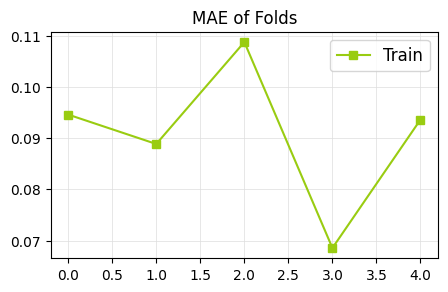

In [17]:
plt.figure(figsize=(5, 3), dpi=100)
ax = plt.plot(MAEs, label='Train', marker='s', color='#99cc11')


plt.title('MAE of Folds')
xtickslocs = np.arange(1, 5, step=1)
plt.legend(loc='best', fontsize='large')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

## **CC of Folds**

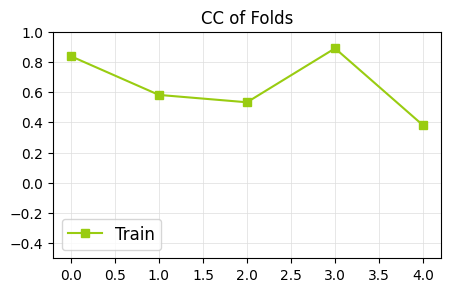

In [18]:
plt.figure(figsize=(5, 3), dpi=100)
ax = plt.plot(CCs, label='Train', marker='s', color='#99cc11')

#plt.plot(history.history['val_loss'], label='Validation')

plt.title('CC of Folds')
#plt.axis([0, k_folds-1, 0, 0.3])
plt.ylim(-0.5, 1)
xtickslocs = np.arange(1, 5, step=1)
plt.legend(loc='best', fontsize='large')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

## **Loss**

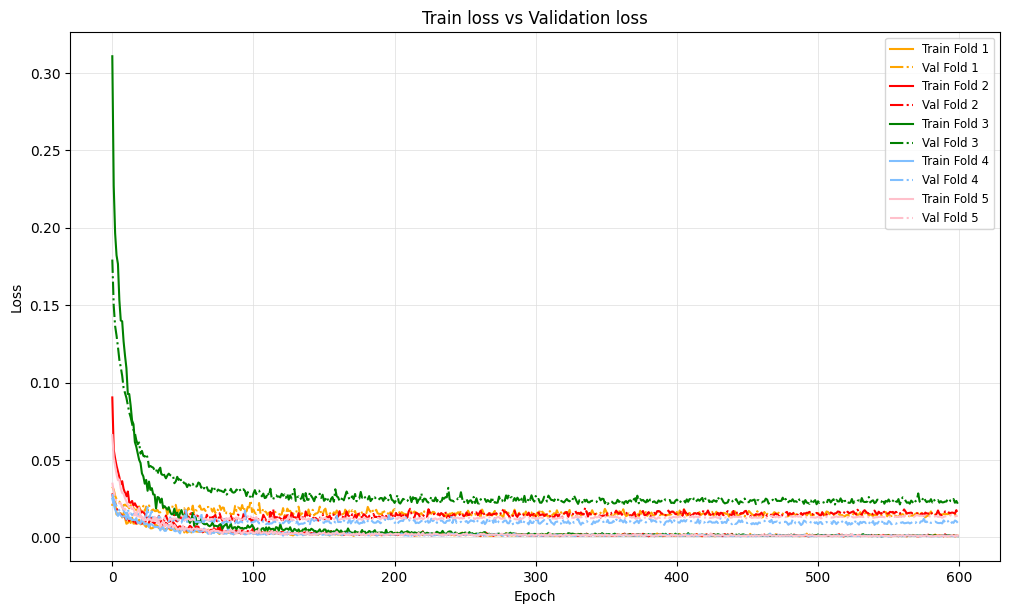

In [19]:
plt.figure(figsize=(12, 7), dpi=100)
plt.title('Train loss vs Validation loss')

plt.plot(CV_history[0].history['loss'], label='Train Fold 1', color='orange')
plt.plot(CV_history[0].history['val_loss'], label='Val Fold 1', color='orange', linestyle = "dashdot")

plt.plot(CV_history[1].history['loss'], label='Train Fold 2', color='red', )
plt.plot(CV_history[1].history['val_loss'], label='Val Fold 2', color='red', linestyle = "dashdot")

plt.plot(CV_history[2].history['loss'], label='Train Fold 3', color='green', )
plt.plot(CV_history[2].history['val_loss'], label='Val Fold 3', color='green', linestyle = "dashdot")

plt.plot(CV_history[3].history['loss'], label='Train Fold 4', color='#80bfff', )
plt.plot(CV_history[3].history['val_loss'], label='Val Fold 4', color='#80bfff', linestyle = "dashdot")

plt.plot(CV_history[4].history['loss'], label='Train Fold 5', color='#FFC0CB', )
plt.plot(CV_history[4].history['val_loss'], label='Val Fold 5', color='#FFC0CB', linestyle = "dashdot")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize='small')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

## **MAE**

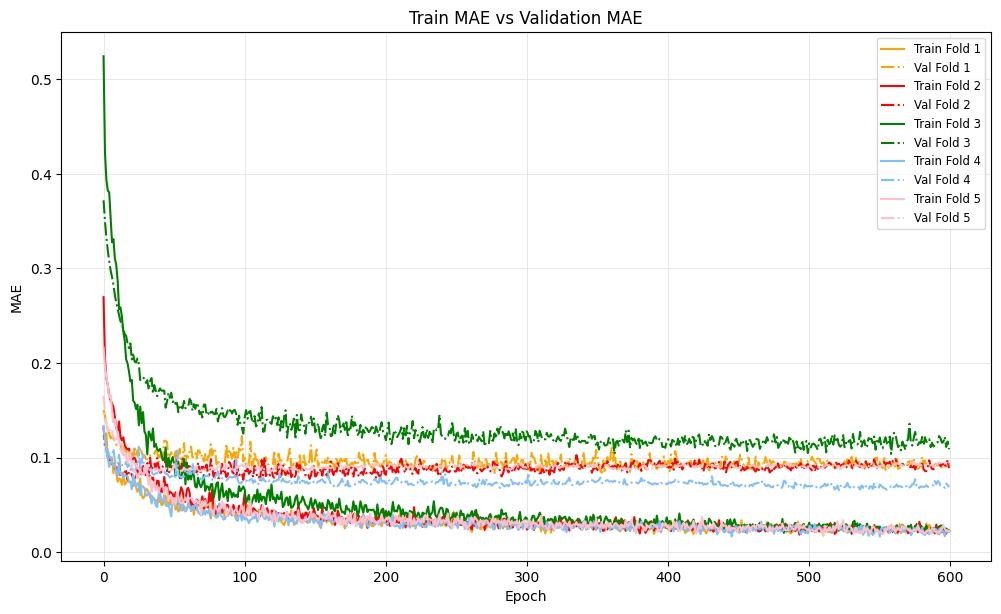

In [20]:
plt.figure(figsize=(12, 7), dpi=100)
plt.title('Train MAE vs Validation MAE')

plt.plot(CV_history[0].history['mae'], label='Train Fold 1', color='orange')
plt.plot(CV_history[0].history['val_mae'], label='Val Fold 1', color='orange', linestyle = "dashdot")

plt.plot(CV_history[1].history['mae'], label='Train Fold 2', color='red', )
plt.plot(CV_history[1].history['val_mae'], label='Val Fold 2', color='red', linestyle = "dashdot")

plt.plot(CV_history[2].history['mae'], label='Train Fold 3', color='green', )
plt.plot(CV_history[2].history['val_mae'], label='Val Fold 3', color='green', linestyle = "dashdot")

plt.plot(CV_history[3].history['mae'], label='Train Fold 4', color='#80bfff', )
plt.plot(CV_history[3].history['val_mae'], label='Val Fold 4', color='#80bfff', linestyle = "dashdot")

plt.plot(CV_history[4].history['mae'], label='Train Fold 5', color='#FFC0CB', )
plt.plot(CV_history[4].history['val_mae'], label='Val Fold 5', color='#FFC0CB', linestyle = "dashdot")

plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='best', fontsize='small')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

## **CC**

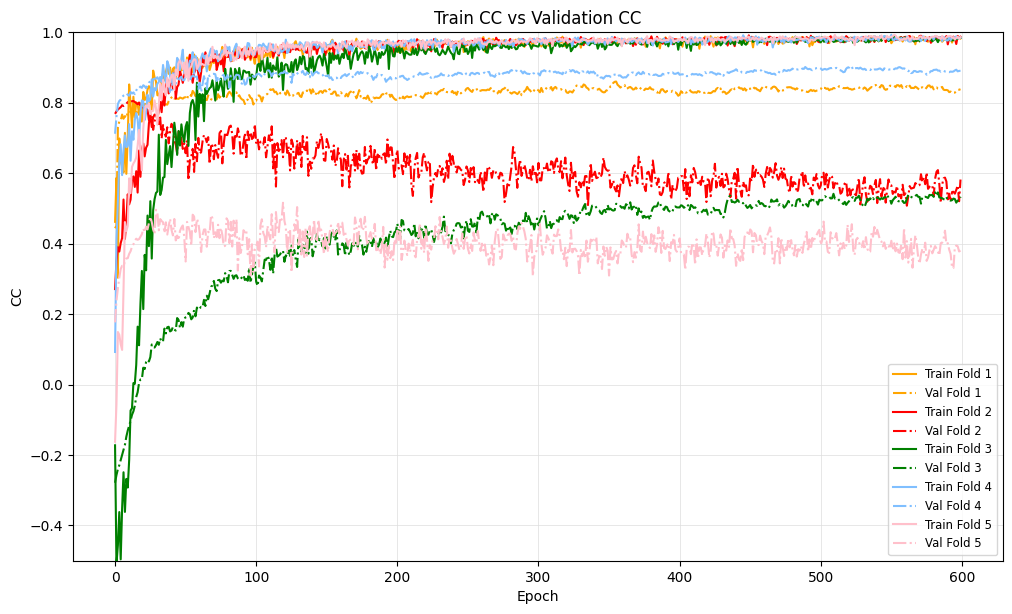

In [31]:
plt.figure(figsize=(12, 7), dpi=100)
plt.title('Train CC vs Validation CC')

plt.plot(CV_history[0].history['CC'], label='Train Fold 1', color='orange')
plt.plot(CV_history[0].history['val_CC'], label='Val Fold 1', color='orange', linestyle = "dashdot")

plt.plot(CV_history[1].history['CC'], label='Train Fold 2', color='red', )
plt.plot(CV_history[1].history['val_CC'], label='Val Fold 2', color='red', linestyle = "dashdot")

plt.plot(CV_history[2].history['CC'], label='Train Fold 3', color='green', )
plt.plot(CV_history[2].history['val_CC'], label='Val Fold 3', color='green', linestyle = "dashdot")

plt.plot(CV_history[3].history['CC'], label='Train Fold 4', color='#80bfff', )
plt.plot(CV_history[3].history['val_CC'], label='Val Fold 4', color='#80bfff', linestyle = "dashdot")


plt.plot(CV_history[4].history['CC'], label='Train Fold 5', color='#FFC0CB', )
plt.plot(CV_history[4].history['val_CC'], label='Val Fold 5', color='#FFC0CB', linestyle = "dashdot")

plt.xlabel('Epoch')
plt.ylabel('CC')
plt.ylim(-0.5, 1)
plt.legend(loc='best', fontsize='small')
plt.grid(color='#ddd', ls = '-', lw = 0.5)

#print(np.mean(CV_history[0].history['CC']))
#print(np.mean(CV_history[0].history['val_CC']))

plt.show()


# **Predict Pattern**

Patterns of Estimated Emotion Response from **Training Data**


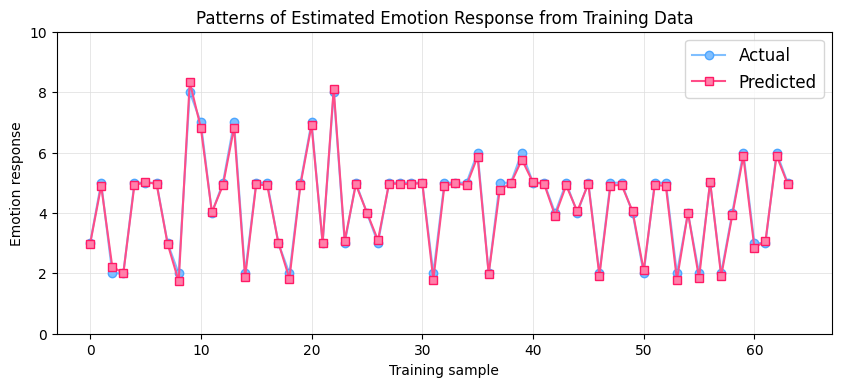

In [22]:
plt.figure(figsize=(10, 4), dpi=100)
plt.plot(train_data_y[0]*10, label='Actual',color='#80bfff', marker='o', MarkerEdgeColor='#4da6ff',MarkerFaceColor='#80bfff')
plt.plot(pred_val_tr[0]*10, label='Predicted', marker='s', color='#ff4d88', MarkerEdgeColor='#ff1a66',MarkerFaceColor='#ff80aa')

plt.xlim(-3, y_tr.shape[0] + 3)
plt.ylim([0, 10])
plt.title('Patterns of Estimated Emotion Response from Training Data')
plt.xlabel('Training sample')
plt.ylabel('Emotion response')
plt.legend(loc='best', fontsize='large')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

Patterns of Estimated Emotion Response from **Test Data**

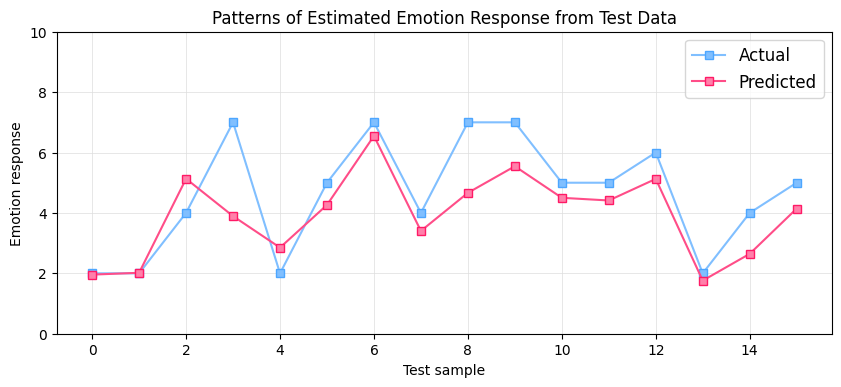

In [23]:
plt.figure(figsize=(10, 4), dpi=100)

plt.plot(val_data_y[0]*10, label='Actual', marker='s', color='#80bfff', MarkerEdgeColor='#4da6ff',MarkerFaceColor='#80bfff')
plt.plot(pred_val_ts[0]*10, label='Predicted', marker='s', color='#ff4d88', MarkerEdgeColor='#ff1a66',MarkerFaceColor='#ff80aa')

plt.ylim([0, 10])
plt.title('Patterns of Estimated Emotion Response from Test Data')
plt.xlabel('Test sample')
plt.ylabel('Emotion response')
plt.legend(loc='best', fontsize='large')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

### **Predict Pattern for all Folds**

In [24]:
YVal = np.vstack([val_data_y[0], val_data_y[1], val_data_y[2], val_data_y[3], val_data_y[4]])

PredVal = np.vstack([pred_val_ts[0], pred_val_ts[1], pred_val_ts[2], pred_val_ts[3], pred_val_ts[4]])

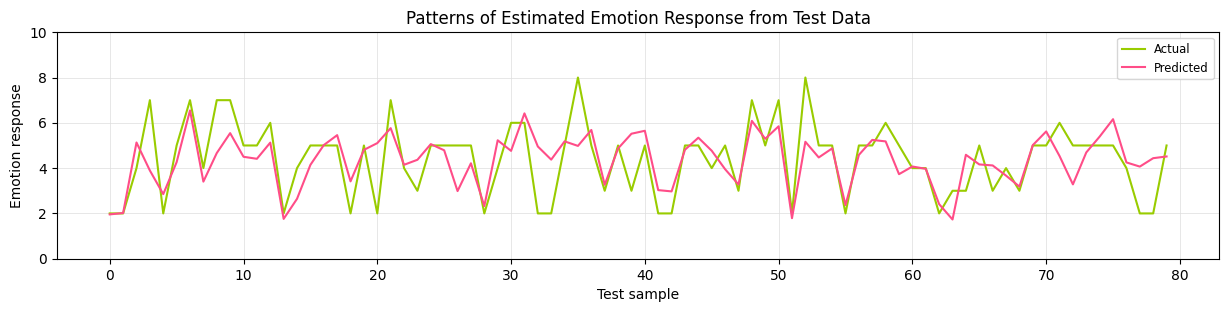

In [32]:
plt.figure(figsize=(15, 3), dpi=100)

plt.plot(YVal*10, label='Actual', color='#9C0', marker='o', MarkerFaceColor='#9C0', markersize=0)
plt.plot(PredVal*10, label='Predicted', color='#ff4d88', marker='o', MarkerFaceColor='#ff80aa', markersize=0)

plt.ylim([0, 10])
plt.title('Patterns of Estimated Emotion Response from Test Data')
plt.xlabel('Test sample')
plt.ylabel('Emotion response')
plt.legend(loc='best', fontsize='small')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

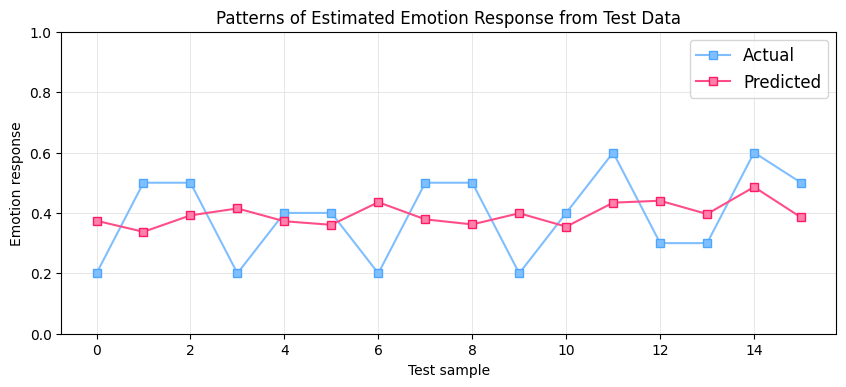

In [26]:
x_test  = np.reshape(x_test , (x_test.shape[0] , 1, x_test.shape[1] ))

#make preediction
pred = model.predict(x_test)

plt.figure(figsize=(10, 4), dpi=100)
plt.plot(y_test, label='Actual', marker='s', color='#80bfff', MarkerEdgeColor='#4da6ff',MarkerFaceColor='#80bfff')
plt.plot(pred, label='Predicted', marker='s', color='#ff4d88', MarkerEdgeColor='#ff1a66',MarkerFaceColor='#ff80aa')
plt.ylim([0, 1])
plt.title('Patterns of Estimated Emotion Response from Test Data')
plt.xlabel('Test sample')
plt.ylabel('Emotion response')
plt.legend(loc='best', fontsize='large')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()